## Analyse Benchmark Testbed

In [12]:
%load_ext autoreload
import trafpy
import trafpy.generator as tpg

import os
import json
import glob
import pickle



JOBCENTRIC = True



# DATA_NAME = 'social_media_cloud_k_4_L_2_n_4_chancap500_numchans1_mldat2e6_bidirectional'
# DATA_NAME = 'rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional'
DATA_NAME = 'jobcentric_prototyping_k_4_L_2_n_16_chancap1_numchans1_mldat3e3_bidirectional'


# path_to_benchmark_data = '/scratch/datasets/trafpy/management/flowcentric/{}_testbed_data_v3.obj'.format(DATA_NAME)
# path_to_testbed_data = '/scratch/datasets/trafpy/management/flowcentric/{}_slotsize_1000.0_testbed_data'.format(DATA_NAME)
# path_to_testbed_data = '/rdata/ong/trafpy/management/flowcentric/{}_slotsize_1000.0_testbed_data'.format(DATA_NAME)
path_to_testbed_data = '/rdata/ong/trafpy/management/jobcentric/{}_slotsize_10.0_testbed_data'.format(DATA_NAME)


if os.path.isdir(path_to_testbed_data):
    # data split into separate files in a directory
    separate_files = True
    # load paths to testbed data dirs
    testbed_data_list = sorted(glob.glob(path_to_testbed_data + '/*'))
    print(testbed_data_list)
    envs = []
    for testbed_path in testbed_data_list:
        try:
            filehandler = open(testbed_path+'/simulation.obj', 'rb')
            envs.append(pickle.load(filehandler))
        except FileNotFoundError:
            print('No simulation.obj in {}'.format(testbed_path))
        
else:
    # all data stored in single file
    separate_files = False
    # load raw testbed data
    filehandler = open(path_to_benchmark_data, 'rb')
    testbed_data = pickle.load(filehandler)
    print(testbed_data.keys())
    # unpack env dicts into list of env objects
    envs = testbed_data['envs']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/rdata/ong/trafpy/management/jobcentric/jobcentric_prototyping_k_4_L_2_n_16_chancap1_numchans1_mldat3e3_bidirectional_slotsize_10.0_testbed_data/benchmark_jobcentric_load_0.1_repeat_0_scheduler_SRPT']


In [13]:
%autoreload
import trafpy
from trafpy.manager import EnvAnalyser, EnvsPlotter

import os

# analyse
analysers = [EnvAnalyser(env, time_units='\u03BCs', info_units='B', subject_class_name=env.scheduler.scheduler_name) for env in envs]
for analyser in analysers:
    env_analyser_database_path = path_to_testbed_data+'/'+analyser.env.sim_name
    analyser.compute_metrics(measurement_start_time='auto', # 'auto' None
                             measurement_end_time='auto', # 'auto' None
                             env_analyser_database_path=env_analyser_database_path,
                             overwrite=False,
                             print_summary=True)


Computing metrics for env benchmark_jobcentric_load_0.1_repeat_0_scheduler_SRPT...
Overwriting /rdata/ong/trafpy/management/jobcentric/jobcentric_prototyping_k_4_L_2_n_16_chancap1_numchans1_mldat3e3_bidirectional_slotsize_10.0_testbed_data/benchmark_jobcentric_load_0.1_repeat_0_scheduler_SRPT/env_analyser_database...
Computing job arrival metrics for env benchmark_jobcentric_load_0.1_repeat_0_scheduler_SRPT...
Computed job arrival metrics for env benchmark_jobcentric_load_0.1_repeat_0_scheduler_SRPT in 2.6394636631011963 s.
Computing job completion metrics for env benchmark_jobcentric_load_0.1_repeat_0_scheduler_SRPT...
Computed job completion metrics for env benchmark_jobcentric_load_0.1_repeat_0_scheduler_SRPT in 0.6051976680755615 s.
Computing job queued metrics for env benchmark_jobcentric_load_0.1_repeat_0_scheduler_SRPT...
Computed job queued metrics for env benchmark_jobcentric_load_0.1_repeat_0_scheduler_SRPT in 0.7623918056488037 s.
Computing job dropped metrics for env bench

,Load,Subject,T-Score,Mean FCT (μs),p99 FCT (μs),Max FCT (μs),Throughput Frac,Frac Flows Dropped,Frac Info Dropped,Mean JCT (μs),p99 JCT (μs),Max JCT (μs),Frac Jobs Dropped
0,0.08,SRPT,-9861.281567,10.7,19.2,19.7,0.951079,0.0489,0.0489,177.5,243.8,247.5,0.712


,Load,Mean FCT (μs),p99 FCT (μs),Max FCT (μs),Throughput Frac,Frac Flows Dropped,Frac Info Dropped,Mean JCT (μs),p99 JCT (μs),Max JCT (μs),Frac Jobs Dropped
0,0.08,SRPT,SRPT,SRPT,SRPT,SRPT,SRPT,SRPT,SRPT,SRPT,SRPT


,Load,Mean FCT (μs),p99 FCT (μs),Max FCT (μs),Throughput Frac,Frac Flows Dropped,Frac Info Dropped,Mean JCT (μs),p99 JCT (μs),Max JCT (μs),Frac Jobs Dropped
0,0.08,SRPT,SRPT,SRPT,SRPT,SRPT,SRPT,SRPT,SRPT,SRPT,SRPT


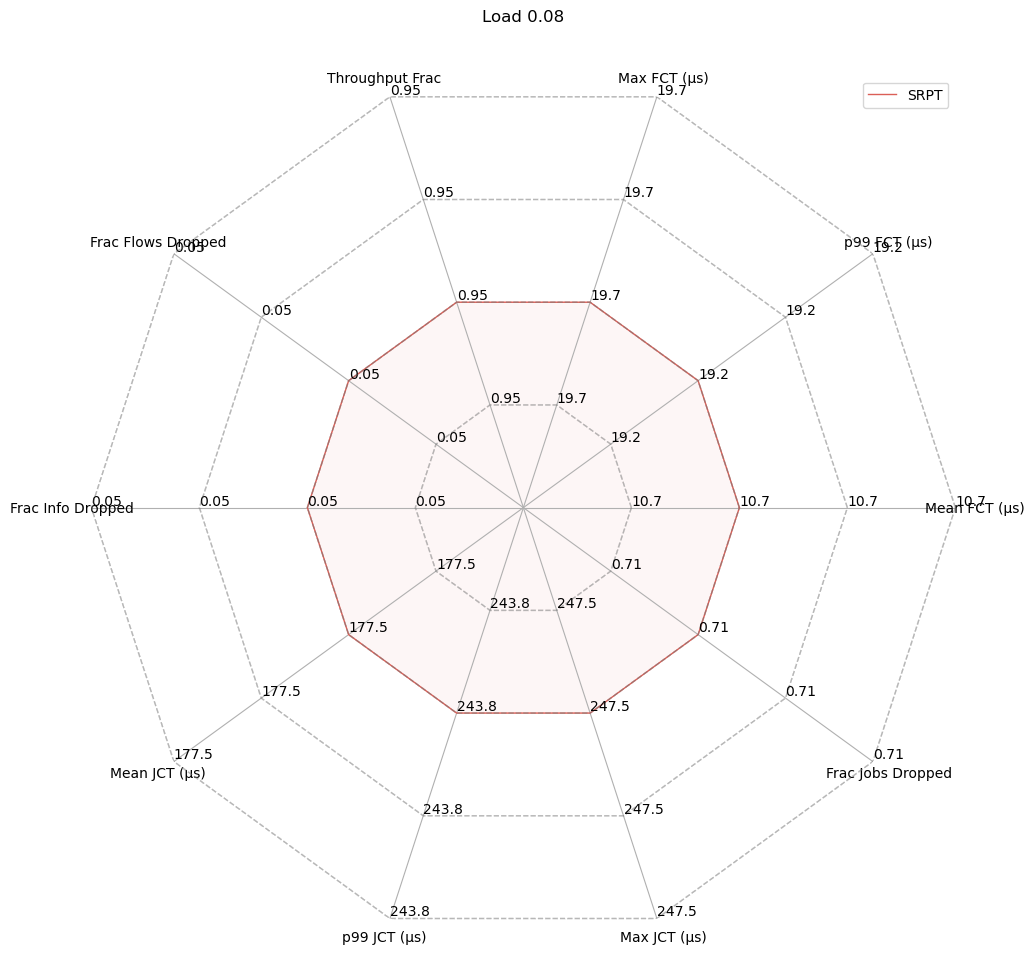

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


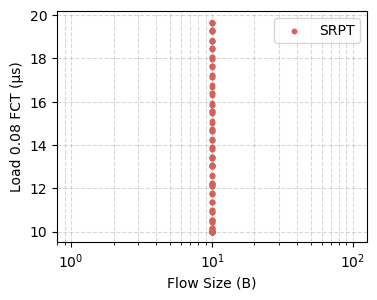

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


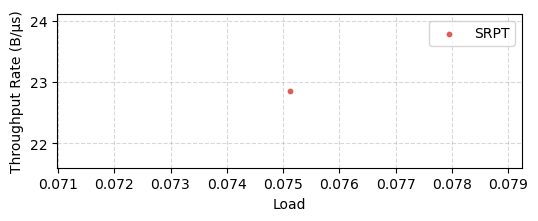

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


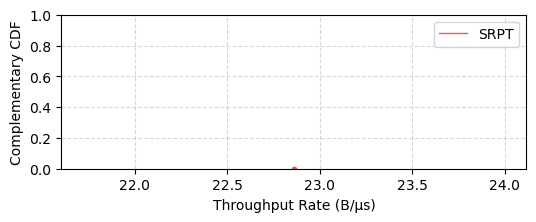

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


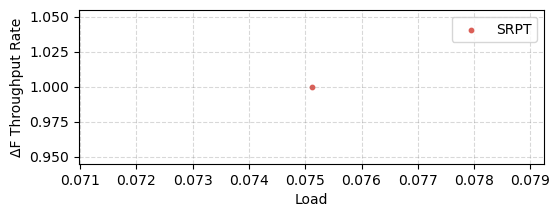

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


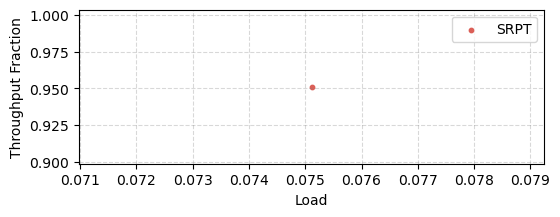

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


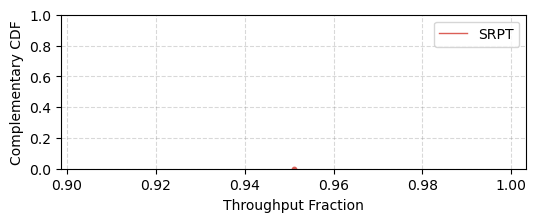

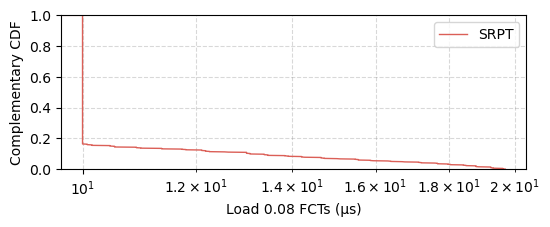

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


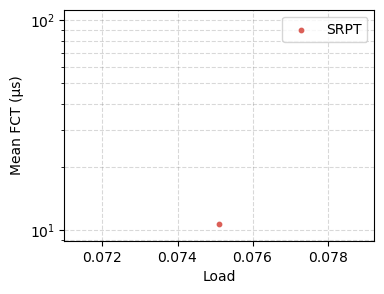

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


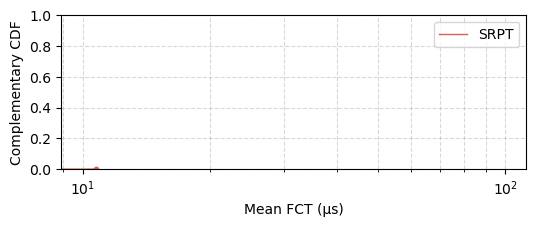

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


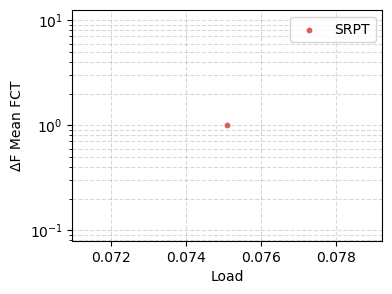

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


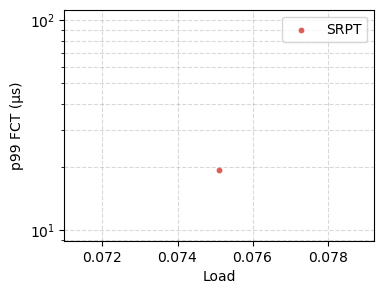

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


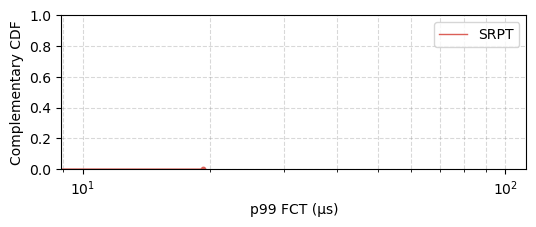

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


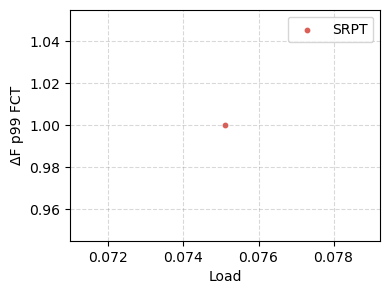

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


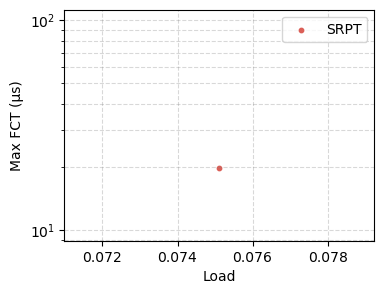

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


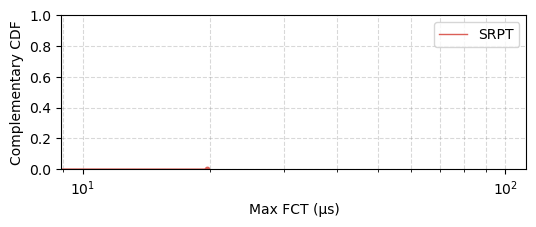

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


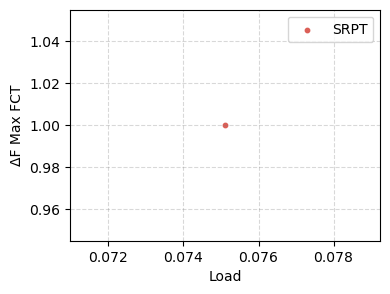

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


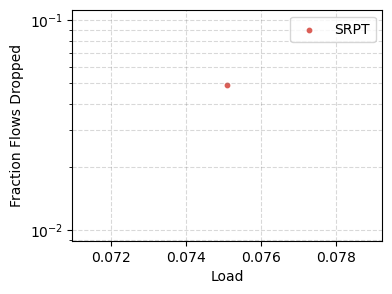

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


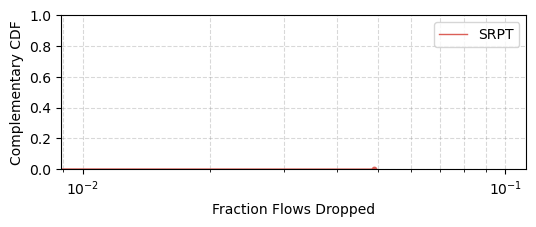

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


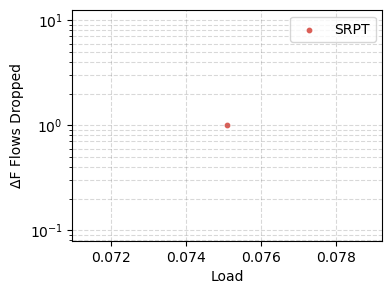

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


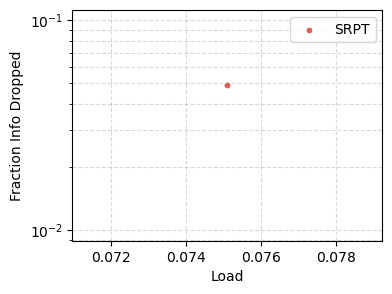

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


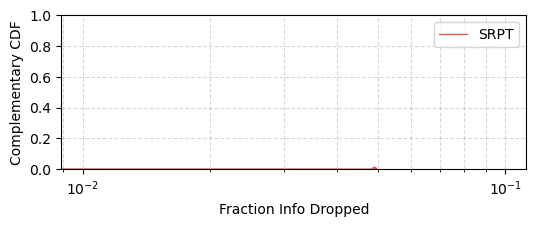

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


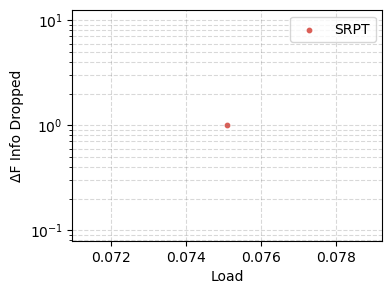

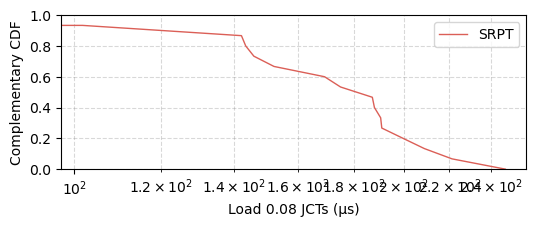

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


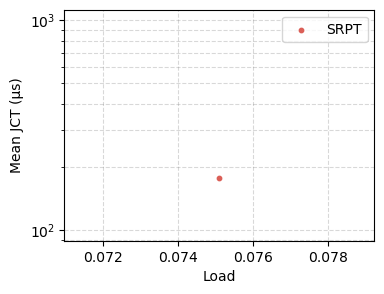

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


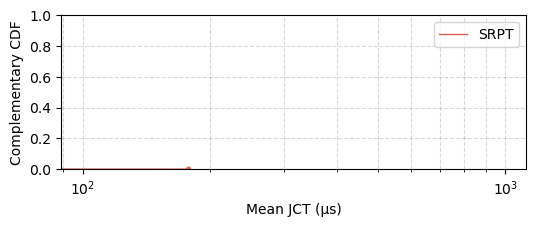

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


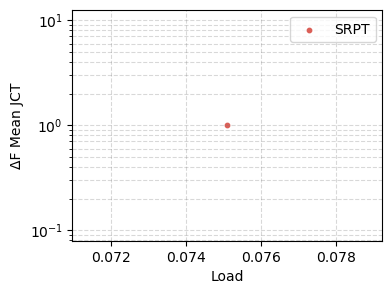

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


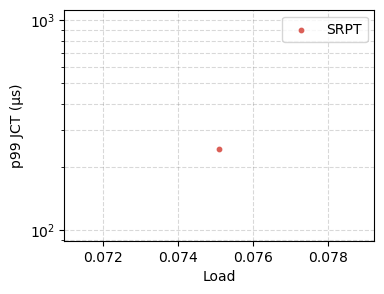

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


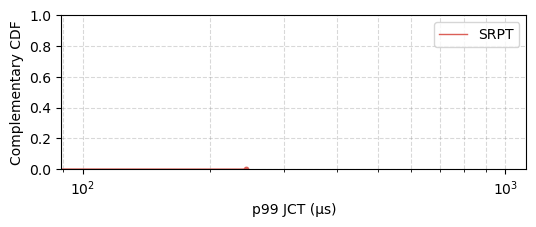

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


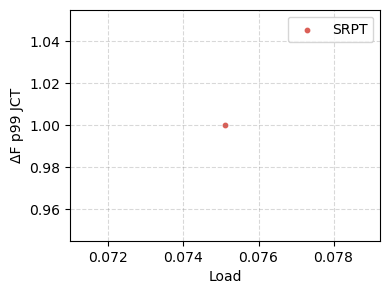

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


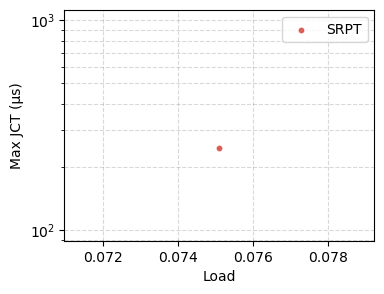

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


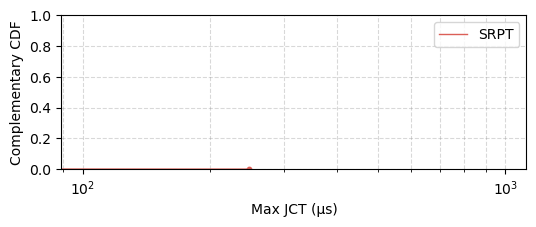

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


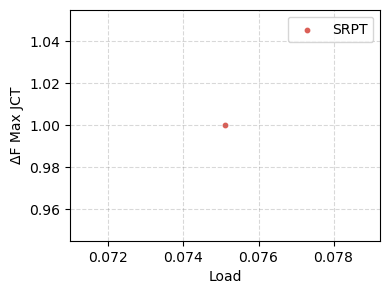

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


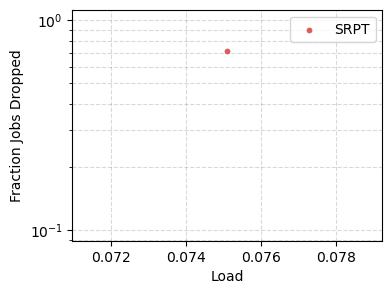

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


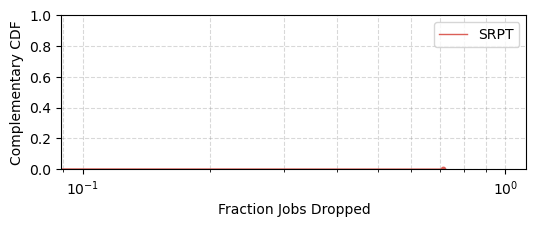

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


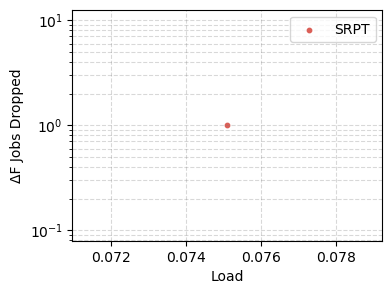

Time to plot: 35.064035415649414


In [17]:
%autoreload
import trafpy
from trafpy.manager import EnvAnalyser, EnvsPlotter

import time


start = time.time()
    
# plot
plotter = EnvsPlotter(time_units='\u03BCs', info_units='B')
_ = plotter.display_t_score_table(*analysers, display_table=True)
# raise Exception()
# _ = plotter.plot_t_score_scatter(*analysers, gridlines=True, figsize=(4, 3), legend_ncol=2)

# COMMENT IF HAVEN'T TRACKED QUEUE EVOLUTION AND SCHEDULER DECISION COLOUR GRID
# _ = plotter.plot_src_dst_queue_evolution_for_different_loads('server_2', 'server_10', 'queue_lengths_num_flows', *analysers)
# _ = plotter.plot_src_dst_queue_evolution_for_different_loads('server_2', 'server_10', 'queue_lengths_info_units', *analysers)
# _ = plotter.plot_demand_slot_colour_grid_for_different_schedulers(*analysers)

# COMMENT IF WANT TO SAVE TIME
# _ = plotter.plot_link_utilisation_vs_time_for_different_loads(*analysers, mean_period=10, figsize=(6, 2), legend_ncol=2, plot_legend=False) # mean_period=2500
# _ = plotter.plot_link_concurrent_demands_vs_time_for_different_loads(*analysers, mean_period=500)




_ = plotter.plot_demand_completion_time_vs_size_for_different_loads(*analysers, gridlines=True, figsize=(4, 3), legend_ncol=2)
_ = plotter.plot_throughput_rate_vs_load(*analysers, plot_bar_charts=False, gridlines=True, figsize=(6, 2), legend_ncol=2)
_ = plotter.plot_throughput_frac_vs_load(*analysers, plot_bar_charts=False, gridlines=True, figsize=(6, 2), legend_ncol=2)
_ = plotter.plot_fcts_cdf_for_different_loads(*analysers, gridlines=True, figsize=(6, 2), legend_ncol=2)
_ = plotter.plot_mean_fct_vs_load(*analysers, logscale=True, gridlines=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)
_ = plotter.plot_99th_percentile_fct_vs_load(*analysers, logscale=True, gridlines=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)
_ = plotter.plot_max_fct_vs_load(*analysers, gridlines=True, logscale=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)
_ = plotter.plot_fraction_of_arrived_flows_dropped_vs_load(*analysers, logscale=True, gridlines=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)
_ = plotter.plot_fraction_of_arrived_info_dropped_vs_load(*analysers, logscale=True, gridlines=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)

if JOBCENTRIC:
    _ = plotter.plot_jcts_cdf_for_different_loads(*analysers, gridlines=True, figsize=(6, 2), legend_ncol=2)
    _ = plotter.plot_mean_jct_vs_load(*analysers, logscale=True, gridlines=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)
    _ = plotter.plot_99th_percentile_jct_vs_load(*analysers, logscale=True, gridlines=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)
    _ = plotter.plot_max_jct_vs_load(*analysers, gridlines=True, logscale=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)
    _ = plotter.plot_fraction_of_arrived_jobs_dropped_vs_load(*analysers, logscale=True, gridlines=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)



end = time.time()
print('Time to plot: {}'.format(end-start))

In [ ]:
# CUSTOM RADAR PLOT(S)
%load_ext autoreload
%autoreload
import trafpy.generator as tpg

time_units = '\u03BCs'
info_units = 'B'

plot_dict = {'Mean FCT ({})'.format(time_units): {'range': [0, 1], 'classes': {'class1': 0.2,
                                                         'class2': 0.4}},
             'p99 FCT ({})'.format(time_units): {'range': [0, 100], 'classes': {'class1': 60,
                                                           'class2': 20}},
             'Max FCT ({})'.format(time_units): {'range': [1, 5], 'classes': {'class1': 2,
                                                         'class2': 5}},
             'Throughput Rate ({}/{})'.format(info_units, time_units): {'range': [0, 10], 'classes': {'class1': 7,
                                                          'class2': 3}},
             'Frac Info Dropped': {'range': [0, 10], 'classes': {'class1': 7,
                                                          'class2': 3}},
             'Frac Flows Dropped': {'range': [10, 0], 'classes': {'class1': 1,
                                                          'class2': 2}}
            }

_ = tpg.plot_radar(plot_dict)

# Custom Plots

In [ ]:
# PLOT SCHEDULER SENSITIVITY TO LOAD
%load_ext autoreload
%autoreload
import trafpy.generator as tpg

from collections import defaultdict
import sigfig


def get_summary_dict(analysers, headers, time_units='', info_units=''):
    summary_dict = {header: [] for header in headers}
    for analyser in analysers:
        # self._check_analyser_valid(analyser)
        summary_dict['Load'].append(round(analyser.load_frac, 2))
        summary_dict['Subject'].append(analyser.subject_class_name)
        summary_dict['T-Score'].append(analyser.t_score)
        summary_dict['Mean FCT ({})'.format(time_units)].append(round(analyser.mean_fct, 1))
        summary_dict['p99 FCT ({})'.format(time_units)].append(round(analyser.nn_fct, 1))
        summary_dict['Max FCT ({})'.format(time_units)].append(round(analyser.max_fct, 1))
        summary_dict['Throughput Frac'].append(round(analyser.throughput_frac, 1))
        summary_dict['Frac Flows Dropped'].append(sigfig.round(analyser.dropped_flow_frac, sigfigs=3))
        summary_dict['Frac Info Dropped'].append(sigfig.round(analyser.dropped_info_frac, sigfigs=3))
    return summary_dict



time_units = '\u03BCs'
info_units = 'B'
headers = ['Load',
           'T-Score',
           'Subject',
           'Mean FCT ({})'.format(time_units),
           'p99 FCT ({})'.format(time_units),
           'Max FCT ({})'.format(time_units),
           'Throughput Frac',
           'Frac Info Dropped',
           'Frac Flows Dropped']
dont_plot_headers = ['Load', 'T-Score', 'Subject']
plot_headers = [header for header in headers if header not in dont_plot_headers]
# determine if higher is better for each header
is_higher_better = {}
for header in headers:
    if header == 'T-Score' or header == 'Throughput Frac':
        is_higher_better[header] = True
    else:
        is_higher_better[header] = False

scheduler_to_analysers = {}
for analyser in analysers:
    if analyser.env.scheduler.scheduler_name not in scheduler_to_analysers:
        scheduler_to_analysers[analyser.env.scheduler.scheduler_name] = [analyser]
    else:
        scheduler_to_analysers[analyser.env.scheduler.scheduler_name].append(analyser)

for scheduler_name in scheduler_to_analysers.keys():
    nested_dict = lambda: defaultdict(nested_dict)
    plot_dict = nested_dict()
    
    anys = scheduler_to_analysers[scheduler_name]
    summary_dict = get_summary_dict(anys, headers, time_units=time_units, info_units=info_units)
    
    for header in plot_headers:
        min_val, max_val = min(summary_dict[header]), max(summary_dict[header])
        
#         if is_higher_better[header]:
#             # want higher (better) values on outer radar edge -> don't flip range
#             _range = [0.9*min(summary_dict[header]), 1.1*max(summary_dict[header])]
#         else:
#             # want lower (better) values on outer radar edge -> flip range
#             _range = [1.1*max(summary_dict[header]), 0.9*min(summary_dict[header])]
            
        diff = max(max_val - min_val, 1e-9)
        min_val -= (0.1*diff)
        max_val += (0.1*diff)
        _range = [min_val, max_val]
#         _range = [max(min_val, 1e-9), max(max_val, 1e-9)]
        if not is_higher_better[header]:
            # flip axis
            _range = _range[::-1]

        plot_dict[header]['range'] = _range
        for i, load in enumerate(summary_dict['Load']):
            plot_dict[header]['classes']['Load {}'.format(str(load))] = summary_dict[header][i]
        
    tpg.plot_radar(plot_dict, 
                   title=scheduler_name,
                   fill=True,
                   fill_alpha=0.05,
                   figsize=(12.8, 9.6))
        
    

In [ ]:
# %autoreload
# import trafpy
# import trafpy.generator as tpg
# from trafpy.manager import RandomAgent, RWA, Demand, DCN, EnvAnalyser
# import json

# DATA_BAME = 'artificial_light_chancap10'
# path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/benchmark_data/{}_benchmark_data.json'.format(DATA_NAME)
# benchmark_data = json.loads(tpg.load_data_from_json(path_to_benchmark_data))
# benchmarks = list(benchmark_data.keys())

# SLOT_SIZE = 1.0
# PACKET_SIZE = 1
# NUM_CHANNELS = 1
# NUM_K_PATHS = 1
# MAX_FLOWS = 10
# MAX_TIME = None

In [ ]:
# network = tpg.gen_fat_tree(k=3, N=2, num_channels=1, server_to_rack_channel_capacity=10)
# rwa = RWA(tpg.gen_channel_names(NUM_CHANNELS), NUM_K_PATHS)
# scheduler = RandomAgent(network, rwa, slot_size=SLOT_SIZE, packet_size=PACKET_SIZE)

# num_benchmark_tests = 0
# for benchmark in benchmarks:
#     for load in benchmark_data[benchmark]:
#         for repeat in benchmark_data[benchmark][load]:
#             num_benchmark_tests += 1

# for benchmark in benchmarks:
#     for load in list(benchmark_data[benchmark].keys()):
#         for repeat in benchmark_data[benchmark][load]:
#             if json.loads(load) == 0.1 and scheduler.scheduler_name == 'random':
#                 demand_data = benchmark_data[benchmark][load][repeat]
#                 demand = tpg.Demand(demand_data)
#                 env = DCN(network, demand, scheduler, num_k_paths=NUM_K_PATHS, slot_size=SLOT_SIZE, max_flows=MAX_FLOWS, max_time=MAX_TIME)
#                 print(env.slot_size)
                
#                 observation = env.reset()
#                 scheduler.register_env(env)
                
#                 while True:
#                     action = scheduler.get_action(observation)
#                     observation, reward, done, info = env.step(action)
                    
#                     if done:
#                         print('Completed')
#                         analyser = EnvAnalyser(env)
#                         analyser.compute_metrics(print_summary=True)

In [ ]:
# packet size = info
# slot size = sec
# min bandwidth in network = info per sec

# assume that 1 packet size of info can be transferred per sub slot
# info per sub slot = 1 packet = packet size
# sub slot size = (info per sub slot / min bandwidth in network) * slot size

In [ ]:
a = None
if a is not None:
    print('not none')
else:
    print('None')

In [ ]:
increment_time = 1.001
print(round(1-(increment_time-1),6))

In [ ]:
ep_link_capacity = 500
